# The Organizations API: Features Overview

This tutorial provides an overview of the [Organizations data source](https://docs.dimensions.ai/dsl/datasource-organizations.html) available via the [Dimensions Analytics API](https://docs.dimensions.ai/dsl/). 

Organizations data in Dimensions is based on [GRID](https://grid.ac/) - the Global Research Identifiers Database. 

The topics covered in this notebook are:

* How to align your affiliation data with GRID/Dimensions using the API [disambiguation service](https://docs.dimensions.ai/dsl/functions.html#function-extract-affiliations)  
* How to retrieve organizations metadata using the [search fields](https://docs.dimensions.ai/dsl/datasource-organizations.html) available
* How to use the [schema API](https://docs.dimensions.ai/dsl/data-sources.html#metadata-api) to obtain some statistics about the Organizations data available  
 


In [1]:
import datetime
print("==\nCHANGELOG\nThis notebook was last run on %s\n==" % datetime.date.today().strftime('%b %d, %Y'))

==
CHANGELOG
This notebook was last run on Jan 25, 2022
==


## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the ['Getting Started' tutorial](https://api-lab.dimensions.ai/cookbooks/1-getting-started/1-Using-the-Dimcli-library-to-query-the-API.html).

In [2]:
!pip install dimcli tqdm plotly -U --quiet

import dimcli
from dimcli.utils import *

import json, sys, time
import pandas as pd
from tqdm.notebook import tqdm as pbar
import plotly.express as px  # plotly>=4.8.1
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login(key=KEY, endpoint=ENDPOINT)
dsl = dimcli.Dsl()

Searching config file credentials for 'https://app.dimensions.ai' endpoint..


==
Logging in..
Dimcli - Dimensions API Client (v0.9.6)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.0
Method: dsl.ini file


---

## 1. Matching affiliation data to GRID IDs using `extract_affiliations`

The API function `extract_affiliations` ([docs](https://docs.dimensions.ai/dsl/functions.html#function-extract-affiliations)) can be used to enrich private datasets including non-disambiguated organizations data with Dimensions IDs, so to then take advantage of the wealth of linked data available in Dimensions.

For example, let's assume our dataset has four columns (*affiliation name*, *city*, *state* and *country*) - any of which can be empty of course. Like this:


In [3]:
affiliations = [
                ['University of Nebraska–Lincoln', 'Lincoln', 'Nebraska', 'United States'],
                ['Tarbiat Modares University', 'Tehran', '', 'Iran'],
                ['Harvard University', 'Cambridge', 'Massachusetts', 'United States'],
                ['China Academy of Chinese Medical Sciences', 'Beijing', '', 'China'],
                ['Liaoning University', 'Shenyang', '', 'China'],
                ['Liaoning Normal University', 'Dalian', '', 'China'],
                ['P.G. Department of Zoology and Research Centre, Shri Shiv Chhatrapati College of Arts, Commerce and Science, Junnar 410502, Pune, India.', '', '', ''],
                ['Sungkyunkwan University', 'Seoul', '', 'South Korea'],
                ['Centre for Materials for Electronics Technology', 'Pune', '', 'India'],
                ['Institut Necker-Enfants Malades (INEM), INSERM U1151-CNRS UMR8253, Université de Paris, Faculté de Médecine, 156 rue de Vaugirard, 75730 Paris Cedex 15, France', '', '', '']
                ]

We want to look up GRID identifiers for those affiliations using the **structured** affiliation matching. 

In [4]:
for d in pbar(affiliations):
    res = dsl.query(f"""extract_affiliations(name="{d[0]}", city="{d[1]}", state="{d[2]}", country="{d[3]}")""")
    time.sleep(0.5)
    print(res.json)

  0%|          | 0/10 [00:00<?, ?it/s]

{'results': [{'geo': {'cities': [{'geonames_id': 5072006, 'name': 'Lincoln'}], 'countries': [{'code': 'US', 'geonames_id': 6252001, 'name': 'United States'}], 'states': [{'code': 'US-NE', 'geonames_id': 5073708, 'name': 'Nebraska'}]}, 'input': {'city': 'Lincoln', 'country': 'United States', 'name': 'University of Nebraska–Lincoln', 'state': 'Nebraska'}, 'institutes': [{'institute': {'city': 'Lincoln', 'country': 'United States', 'id': 'grid.24434.35', 'name': 'University of Nebraska–Lincoln', 'state': 'Nebraska'}, 'metadata': {'requires_manual_review': False}}]}]}
{'results': [{'geo': {'cities': [{'geonames_id': 112931, 'name': 'Tehran'}], 'countries': [{'code': 'IR', 'geonames_id': 130758, 'name': 'Iran'}], 'states': [{'code': None, 'geonames_id': 110791, 'name': 'Tehran'}]}, 'input': {'city': 'Tehran', 'country': 'Iran', 'name': 'Tarbiat Modares University', 'state': ''}, 'institutes': [{'institute': {'city': 'Tehran', 'country': 'Iran', 'id': 'grid.412266.5', 'name': 'Tarbiat Modare

If we combine the affiliation data into a single long string, we can also perform the same king of operation using the **unstructured** affiliation matching. 

In [5]:
# implicit results 
for d in pbar(affiliations):
    merged = f"{d[0]} {d[1]} {d[2]} {d[3]}"
    res = dsl.query(f"""extract_affiliations(affiliation="{merged}")""")
    time.sleep(0.5)
    print(res.json)

  0%|          | 0/10 [00:00<?, ?it/s]

{'results': [{'input': {'affiliation': 'University of Nebraska–Lincoln Lincoln Nebraska United States'}, 'matches': [{'affiliation_part': 'University of Nebraska–Lincoln Lincoln Nebraska United States', 'geo': {'cities': [{'geonames_id': 5072006, 'name': 'Lincoln'}], 'countries': [{'code': 'US', 'geonames_id': 6252001, 'name': 'United States'}], 'states': [{'code': 'US-NE', 'geonames_id': 5073708, 'name': 'Nebraska'}]}, 'institutes': [{'institute': {'city': 'Lincoln', 'country': 'United States', 'id': 'grid.24434.35', 'name': 'University of Nebraska–Lincoln', 'state': 'Nebraska'}, 'metadata': {'requires_manual_review': False}}]}]}]}
{'results': [{'input': {'affiliation': 'Tarbiat Modares University Tehran  Iran'}, 'matches': [{'affiliation_part': 'Tarbiat Modares University Tehran Iran', 'geo': {'cities': [{'geonames_id': 112931, 'name': 'Tehran'}], 'countries': [{'code': 'IR', 'geonames_id': 130758, 'name': 'Iran'}], 'states': [{'code': None, 'geonames_id': 110791, 'name': 'Tehran'}]}

> NOTE: the above commands also support **bulk querying** e.g. to save up API queries - check out the [docs](https://docs.dimensions.ai/dsl/functions.html#function-extract-affiliations) for more info.

## 2. Searching GRID organizations 

This can be done using full text search and/or fielded search. 


### Full-text search 

In [6]:
%%dsldf 
search organizations 
  for "new york" 
return organizations limit 10

Returned Organizations: 10 (total = 247)
Time: 0.56s


,acronym,city_name,country_name,id,latitude,linkout,longitude,name,state_name,types
0,MSK,New York,United States,grid.51462.34,40.764194,[https://www.mskcc.org/],-73.956100,Memorial Sloan Kettering Cancer Center,New York,[Healthcare]
1,NaN,Brooklyn,United States,grid.511519.8,40.691113,[https://www.vascularnyc.com/],-73.963890,Vascular Institute of New York,New York,[Healthcare]
2,NYPC,New York,United States,grid.511327.3,40.804780,[https://www.nyproton.com/],-73.934070,New York Proton Center,New York,[Facility]
3,NaN,New York,United States,grid.511090.c,40.755230,[https://www.journalism.cuny.edu/],-73.988830,Craig Newmark Graduate School of Journalism at...,New York,[Education]
4,CMS,New York,United States,grid.510787.c,40.761470,[https://cmsny.org/],-73.965450,Center for Migration Studies of New York,New York,[Education]
5,NYSCC,Alfred,United States,grid.507867.b,42.253372,[https://www.alfred.edu/academics/colleges-sch...,-77.787575,New York State College of Ceramics,New York,[Education]
6,ILR,New York,United States,grid.507863.f,42.448510,[https://www.ilr.cornell.edu/],-76.478620,New York State School of Industrial and Labor ...,New York,[Education]
7,MVCC,Utica,United States,grid.507861.d,43.076850,[https://www.mvcc.edu/],-75.220120,Mohawk Valley Community College,New York,[Education]
8,CALS,New York,United States,grid.507860.c,42.448290,[https://cals.cornell.edu/#],-76.479390,New York State College of Agriculture & Life S...,New York,[Education]
9,NaN,New York,United States,grid.507859.6,42.447483,[https://www.vet.cornell.edu/],-76.464905,New York State College of Veterinary Medicine,New York,[Education]


In [7]:
%%dsldf 
search organizations 
  for "new york AND community" 
return organizations limit 10

Returned Organizations: 8 (total = 8)
Time: 0.56s


,acronym,city_name,country_name,id,latitude,linkout,longitude,name,state_name,types
0,MVCC,Utica,United States,grid.507861.d,43.076850,[https://www.mvcc.edu/],-75.220120,Mohawk Valley Community College,New York,[Education]
1,NaN,Buffalo,United States,grid.490742.c,42.874810,[https://hfwcny.org/],-78.849690,Health Foundation for Western & Central New York,New York,[Other]
2,NaN,New York,United States,grid.480917.3,40.758870,[http://www.nycommunitytrust.org/],-73.968185,New York Community Trust,New York,[Nonprofit]
3,CNYCF,Syracuse,United States,grid.478715.8,43.056038,[https://www.cnycf.org/],-76.148210,Central New York Community Foundation,New York,[Nonprofit]
4,CSS,New York,United States,grid.475804.a,40.749622,[http://www.cssny.org/],-73.974620,Community Service Society of New York,New York,[Other]
5,LTCCC,New York,United States,grid.475783.a,40.751163,[http://www.ltccc.org/],-73.992470,Long Term Care Community Coalition,New York,[Other]
6,ECC,Williamsville,United States,grid.468887.d,42.960820,[https://www.ecc.edu/],-78.721660,Erie Community College,New York,[Education]
7,KCS,New York,United States,grid.429257.f,40.770954,[https://www.kcsny.org/],-73.786670,Korean Community Services of Metropolitan New ...,New York,[Nonprofit]


### Fielded search 

We can easily look up an organization using its grid ID, eg [grid.468887.d](https://grid.ac/institutes/grid.468887.d). 

In [8]:
%%dsldf 
search organizations 
  where id="grid.468887.d" 
return organizations[all] 

Returned Errors: 1
Time: 0.47s
1 QueryError found
Semantic errors found:
	Field / Fieldset 'all' is not present in Source 'organizations'. Available fields: acronym,city_name,cnrs_ids,country_name,dimensions_url,established,external_ids_fundref,hesa_ids,id,isni_ids,latitude,linkout,longitude,name,nuts_level1_code,nuts_level1_name,nuts_level2_code,nuts_level2_name,nuts_level3_code,nuts_level3_name,organization_child_ids,organization_parent_ids,organization_related_ids,orgref_ids,redirect,ror_ids,state_name,status,types,ucas_ids,ukprn_ids,wikidata_ids,wikipedia_url and available fieldsets: basics,nuts


In [9]:
%%dsldf 
search organizations 
  for "new york" 
  where types in ["Education"]
return organizations limit 10

Returned Organizations: 10 (total = 80)
Time: 0.60s


,city_name,country_name,id,latitude,linkout,longitude,name,state_name,types,acronym
0,New York,United States,grid.511090.c,40.755230,[https://www.journalism.cuny.edu/],-73.988830,Craig Newmark Graduate School of Journalism at...,New York,[Education],NaN
1,New York,United States,grid.510787.c,40.761470,[https://cmsny.org/],-73.965450,Center for Migration Studies of New York,New York,[Education],CMS
2,Alfred,United States,grid.507867.b,42.253372,[https://www.alfred.edu/academics/colleges-sch...,-77.787575,New York State College of Ceramics,New York,[Education],NYSCC
3,New York,United States,grid.507863.f,42.448510,[https://www.ilr.cornell.edu/],-76.478620,New York State School of Industrial and Labor ...,New York,[Education],ILR
4,Utica,United States,grid.507861.d,43.076850,[https://www.mvcc.edu/],-75.220120,Mohawk Valley Community College,New York,[Education],MVCC
5,New York,United States,grid.507860.c,42.448290,[https://cals.cornell.edu/#],-76.479390,New York State College of Agriculture & Life S...,New York,[Education],CALS
6,New York,United States,grid.507859.6,42.447483,[https://www.vet.cornell.edu/],-76.464905,New York State College of Veterinary Medicine,New York,[Education],NaN
7,Ithaca,United States,grid.507858.7,42.449740,[https://www.human.cornell.edu/],-76.479065,New York State University College of Human Eco...,New York,[Education],HumEc
8,New York,United States,grid.493073.a,40.752880,[http://website.aub.edu.lb/nyo/Pages/index.aspx],-73.969040,American University of Beirut New York Office,New York,[Education],AUB
9,New York,United States,grid.487836.6,40.740430,[https://www.csnyc.org/],-73.995630,New York City Foundation for Computer Science ...,New York,[Education],CSNYC


In [10]:
%%dsldf 
search organizations 
  for "new york" 
  where types in ["Education"]
  and country_name != "United States"
return organizations limit 10

Returned Organizations: 8 (total = 8)
Time: 0.58s


,city_name,country_name,id,latitude,linkout,longitude,name,types,acronym,state_name
0,Paris,France,grid.479986.d,48.869614,[http://www.nyu.edu/paris.html],2.346863,New York University Paris,[Education],NaN,NaN
1,Florence,Italy,grid.473731.5,43.795910,[http://www.nyu.edu/florence.html],11.265850,New York University Florence,[Education],NYU,NaN
2,Vancouver,Canada,grid.473728.d,49.284374,[http://nyit.edu/vancouver],-123.116480,New York Institute of Technology,[Education],NYIT,British Columbia
3,Prague,Czechia,grid.449989.1,50.074043,[https://www.unyp.cz/],14.433994,University of New York in Prague,[Education],UNYP,NaN
4,Shanghai,China,grid.449457.f,31.225506,[https://shanghai.nyu.edu/],121.533510,New York University Shanghai,[Education],NaN,NaN
5,Tirana,Albania,grid.444973.9,41.311060,[http://unyt.edu.al/],19.801466,University of New York Tirana,[Education],UNYT,NaN
6,Abu Dhabi,United Arab Emirates,grid.440573.1,24.485000,[https://nyuad.nyu.edu/],54.353000,New York University Abu Dhabi,[Education],NaN,NaN
7,Seoul,South Korea,grid.410685.e,37.377018,[http://www.sunykorea.ac.kr/],126.666770,SUNY Korea,[Education],NaN,NaN


### Returning facets 


In [11]:
%%dsldf 
search organizations 
  for "new york" 
return country_name

Returned Country_name: 10
Time: 0.52s


,count,id
0,238,United States
1,1,Albania
2,1,Canada
3,1,China
4,1,Czechia
5,1,France
6,1,Italy
7,1,South Korea
8,1,United Arab Emirates
9,1,United Kingdom


In [12]:
%%dsldf 
search organizations 
  for "new york" 
  where country_name = "United States"
return types

Returned Types: 8
Time: 0.61s


,count,id
0,72,Education
1,59,Nonprofit
2,39,Government
3,29,Other
4,22,Healthcare
5,9,Archive
6,5,Facility
7,3,Company


### Returning organizations facets from publications

The GRID organization data is used thoughout Dimensions. 

So, for example, one can do a publications search and return organizations as a facet. This allows to take advantage of GRID metadata - e.g. latiture and longitude - in order to quickly build a geograpical visualization. 


In [13]:
q = """
search publications for "coronavirus OR covid-19" 
    where year > 2019 
return research_orgs[basics] limit 50
"""

df = dslquery(q).as_dataframe()
df.head(5)

Returned Research_orgs: 50
Time: 1.26s


,city_name,count,country_name,id,latitude,linkout,longitude,name,state_name,types,acronym
0,Cambridge,9846,United States,grid.38142.3c,42.377052,[http://www.harvard.edu/],-71.116650,Harvard University,Massachusetts,[Education],NaN
1,Oxford,5900,United Kingdom,grid.4991.5,51.753437,[http://www.ox.ac.uk/],-1.254010,University of Oxford,Oxfordshire,[Education],NaN
2,Toronto,5519,Canada,grid.17063.33,43.661667,[http://www.utoronto.ca/],-79.395000,University of Toronto,Ontario,[Education],NaN
3,Baltimore,5289,United States,grid.21107.35,39.328888,[https://www.jhu.edu/],-76.620280,Johns Hopkins University,Maryland,[Education],JHU
4,London,5232,United Kingdom,grid.83440.3b,51.524470,[http://www.ucl.ac.uk/],-0.133982,University College London,NaN,[Education],UCL


In [14]:
fig = px.scatter_geo(df, 
                     lat="latitude", lon="longitude",
                     color="country_name",
                     size="count", 
                     projection="natural earth",
                     hover_name="name",
                     hover_data=['city_name', 'id', 'types']
                     )
fig.show()

## 3. A closer look at the organizations data statistics

The Dimensions Search Language [exposes programmatically metadata](https://docs.dimensions.ai/dsl/data.html#getting-documentation-programmatically), such as supported sources and entities, along with their fields, facets, fieldsets, metrics and search fields. 

In [15]:
%dsldocs organizations

,sources,field,type,description,is_filter,is_entity,is_facet
0,organizations,acronym,string,"GRID acronym of the organization. E.g., ""UT"" f...",True,False,False
1,organizations,city_name,string,"GRID name of the organization country. E.g., ""...",True,False,True
2,organizations,cnrs_ids,string,CNRS IDs for this organization,True,False,False
3,organizations,country_name,string,"GRID name of the organization country. E.g., ""...",True,False,True
4,organizations,dimensions_url,string,Link pointing to the Dimensions web application,False,False,False
5,organizations,established,integer,Year when the organization was estabilished,True,False,False
6,organizations,external_ids_fundref,string,Fundref IDs for this organization,True,False,False
7,organizations,hesa_ids,string,HESA IDs for this organization,True,False,False
8,organizations,id,string,"GRID ID of the organization. E.g., ""grid.26999...",True,False,False
9,organizations,isni_ids,string,ISNI IDs for this organization,True,False,False


We can use the fields information above to draw up some quick statistics re. the organizations source. 

In order to do this, we  use the operator `is not empty` to generate automatically queries like this `search organizations where field_name is not empty return organizations limit 1` and then use the `total_count` field in the JSON we get back for our statistics. 

In [16]:
FIELDS_DATA = dsl_last_results

# one query with `is not empty` for field-filters  
q_template = """search organizations where {} is not empty return organizations[id] limit 1"""

# seed results with total number of orgs
totorgs = dsl.query("""search organizations return organizations[id] limit 1""", verbose=False).count_total
stats = [
    {'filter_by': 'All Organizations (no filter)', 'results' : totorgs}     
]

for index, row in pbar(list(FIELDS_DATA.iterrows())):
    # print("\n===", row['field'])
    q = q_template.format(row['field'], row['field'])
    res = dsl.query(q, verbose=False)
    time.sleep(0.5)
    stats.append({'filter_by': row['field'], 'results' : res.count_total})


# save to a dataframe
df = pd.DataFrame().from_dict(stats)
df.sort_values("results", inplace=True, ascending=False)
df

  0%|          | 0/33 [00:00<?, ?it/s]

,filter_by,results
0,All Organizations (no filter),107202
5,dimensions_url,107202
14,name,107202
9,id,107202
28,status,107202
4,country_name,104670
2,city_name,104598
29,types,104428
11,latitude,103357
13,longitude,103357


### Let's visualize the data with plotly

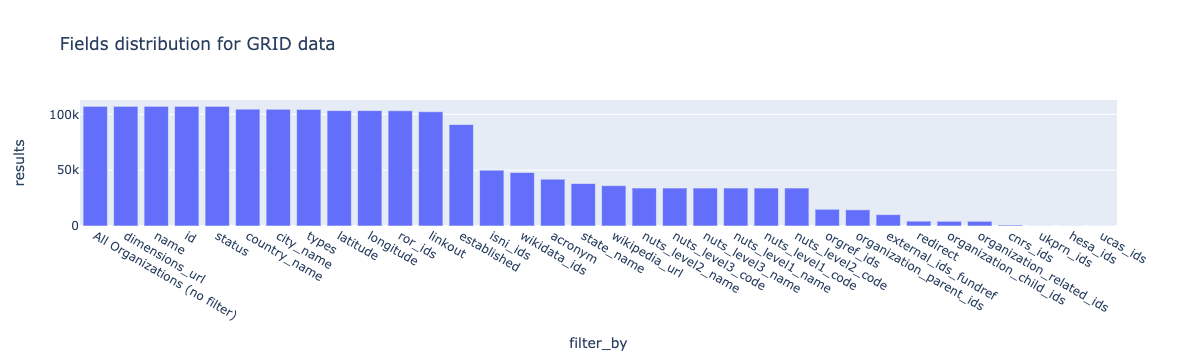

In [17]:
px.bar(df, x="filter_by", y="results", 
       title="Fields distribution for GRID data")

## Where to find out more

Please have a look at the [official documentation](https://docs.dimensions.ai/dsl/data-sources.html) for more information on the GRID source.